# Pre-processing workflow

This script contains the choices made when preprocessing the original article text:
The word count of the OG corpus is 6371235.



1. First we remove double spaces by splitting the text into words and joining them againn
2. To account for instances in which suppression appears in quotation marks, we replace "suppression" with no suppression before removing symbols.
3. We create a list of irrelevant words

In [ ]:
# Installing modules
!pip install nltk
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install sklearn

In [1]:
# Importing modules
import re, nltk, numpy, matplotlib
import pandas as pd
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer 
from sklearn.decomposition import LatentDirichletAllocation
from gensim import corpora
from collections import Counter

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\analo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [30]:
# load categorised data by media ideological affiliation
df = pd.read_csv('C:/Users/analo/OneDrive - University of Glasgow/University of Glasgow/Amsterdam Visit/ASCoR-Project/Data Files/finalcorpus.csv', encoding='latin-1')
df.head()  

,date,maintext,title,source,media_name,ideology,Congress
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,6 Ways the League of Women Voters Has Impacted...,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th
1,2015/02/10,"As state legislatures shift into high gear, ma...",Opportunities for Effective Election Reforms C...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...","Scott Walker Pushes ALEC 'Right to Work' Bill,...",http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,Nevada GOP Pushes New Gun Law Reminiscent Of '...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th


In [4]:
# counting words of original text 
from nltk.tokenize import word_tokenize
text =df['maintext'].apply(str) 
documents = [" ".join(strings.split()) for strings in text] 
string = " ".join(documents)
tokenized = word_tokenize(string)
len(tokenized)

6371235

### Stopwords

I loaded a txt file with common stopwords. I created new stopwords following the title analysis with irrelevant words and also a list of words with a low idf score, so words that are common in the entire corpus,

In [31]:
stop_words_file = 'C:/Users/analo/OneDrive - University of Glasgow/University of Glasgow/Amsterdam Visit/ASCoR-Project/Analysis/Descriptive-Stats/english.stop.txt' # Stopword list
new_stopwords = ['Opinion', 'New', 'Advertisement', 'advertisement','Mr', 'mr', 'Advertisement\r\r\n'] # irrelevant words to add to stopword list
idf_words = ['state', 'states','voting', 'election', 'vote', 'voters', 'voter'] # words with low idf score in entire corpus
stop_words = []

with open(stop_words_file, "r") as f:
    for line in f:
        stop_words.extend(line.split()) 
        
stop_words = stop_words  

In [32]:
# First we create a new column and convert the text column into string so that preprocessing works and get rid of double spaces
df['text']=df['maintext'].apply(str) 
def nospace(raw_text):
    words = raw_text.split() #split into words -> convert string into list
    words = [" ".join(words.split()) for words in words] # remove double spaces by splitting the strings into words and joining these words again
    return " ".join(words) # converting list back to string

df['text'] = df['text'].apply(nospace)

#### 1. Remove irrelevant words

In [33]:
# remove new stop words associated with corpus
def nostop(raw_text):
    cleaned_words = [] # removing capitalised irrelevant words from corpus
    words = raw_text.split()
    for word in words:
        if word not in new_stopwords:
            cleaned_words.append(word)
    return " ".join(cleaned_words) # converting list back to string

df['text'] = df['text'].apply(nostop)

#### 2. Replace "suppression" with no_suppression

In [34]:
def quotations(raw_text):
    text = raw_text.replace('"suppression"', 'no_suppression') 
    text = text.replace('"jim crow"', 'no_jim_crow') 
    return(text)

df['text'] = df['text'].apply(quotations)


In [8]:
test_sentence = 'this is a "suppression", begin video clip to demonstrate u.s. how the function works...!'
quotations(test_sentence)

'this is a no_suppression, begin video clip to demonstrate u.s. how the function works...!'

#### 3. Remove symbols, convert to lower case and remove common stop words

In [18]:
def preprocess(raw_text):
    
    #regular expression keeping only letters 
    #letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)

     # convert to lower case and split into words -> convert string into list
    words = raw_text.lower().split()
    words=[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again

    cleaned_words = []    
    # remove stopwords
    for word in words:
        if word not in stop_words:
            cleaned_words.append(word)

    # converting list back to string
    return " ".join(cleaned_words)

df['text'] = df['text'].apply(preprocess)

#### 4. Remove low idf score words

In [9]:
def idfwords(raw_text):
    cleaned_words = [] # removing capitalised irrelevant words from corpus
    words = raw_text.split()
    for word in words:
        if word not in idf_words:
            cleaned_words.append(word)
    return " ".join(cleaned_words) # converting list back to string

df['text'] = df['text'].apply(idfwords)

#### 5. Filtering words that appear less than 3 times overall

In [54]:
from collections import Counter
from itertools import chain

# split words into lists
v = df['text'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
# compute global word frequency
c = Counter(chain.from_iterable(v))
# filter, join, and re-assign
df['text'] = [' '.join([j for j in i if c[j] > 3]) for i in v]

#### 6. Finding and compounding top bigrams

In [55]:
from nltk.util import ngrams
n_gram = 2
ngram = pd.DataFrame(Counter(ngrams(" ".join(df["text"]).split(), n_gram)).most_common(10))
ngram.columns=['word', 'freq']
ngram

,word,freq
0,"(voting, rights)",7327
1,"(voter, id)",6283
2,"(supreme, court)",4407
3,"(north, carolina)",3582
4,"(united, states)",3319
5,"(civil, rights)",3057
6,"(voter, fraud)",2950
7,"(rights, act)",2688
8,"(voter, registration)",2635
9,"(donald, trump)",2422


Now that we know common bigrams we can go back to preprocessing and join these in the text so that they are subsequently treated as 1 token instead of 2. 

In [19]:
def bigrams(raw_text):
    text = raw_text.replace("supreme court", "supreme_court")
    text = text.replace("donald trump", "donald_trump")
    text = text.replace("joe biden", "joe_biden")
    text = text.replace("jim crow", "jim_crow")
    text = text.replace("kamala harris", "kamala_harris")
    text = text.replace("stacey abrams", "stacey_abrams")
    text = text.replace("hillary clinton", "hillary_clinton")
    text = text.replace("south carolina", "south_carolina")
    text = text.replace("north carolina", "north_carolina")
    text = text.replace("united states", "united_states")
    text = text.replace("fox news", "fox_news")
     # split into words -> convert string into list
    words = text.split()
    words =[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    # converting list back to string
    return " ".join(words)

df['text'] = df['text'].apply(bigrams)

In [23]:
def change(raw_text):
    text = raw_text.replace("donald_trump", "trump")
    text = text.replace("joe_biden", "biden")
    text = text.replace(" id ", " identification ")
    text = text.replace(" id,", " identification,")
    text = text.replace(" id.", " identification.")
     # split into words -> convert string into list
    words = text.split()
    words =[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    # converting list back to string
    return " ".join(words)

df['text'] = df['text'].apply(change)


In [22]:
test_sentence = 'this is a voter id , voter id. voter id, begin video clip to demonstrate u.s. how the function works...!'
change(test_sentence)

'this is a voter identification , voter identification. voter identification, begin video clip to demonstrate u.s. how the function works...!'

#### 7. remove new stop words associated with corpus


In [27]:
new_stopwords2 = ['ve', 'don', 'mr', 'click', 'fox_news', 'hannity'] # irrelevant words to add to stopword list

def newnostop(raw_text):
    cleaned_words = [] # removing capitalised irrelevant words from corpus
    words = raw_text.split()
    for word in words:
        if word not in new_stopwords2:
            cleaned_words.append(word)
    return " ".join(cleaned_words) # converting list back to string

df['text'] = df['text'].apply(newnostop)

In [25]:
def newchange(raw_text):
    text = raw_text.replace("begin video clip", "")
    text = text.replace("click fox_news app", "")
    text = text.replace("html graphic photo", "")
    text = text.replace("listen fox_news", "")
    text = text.replace("classification language english document type news publication type web blog", "")
     # split into words -> convert string into list
    words = text.split()
    words =[" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    # converting list back to string
    return " ".join(words)

df['text'] = df['text'].apply(newchange)

#### 8. create a lemmatised text column

In [60]:
def lemma(raw_text):
     # convert to lower case and split into words -> convert string into list
    words = raw_text.lower().split()
    words= [" ".join(words.split()) for words in words]   # remove double spaces by splitting the strings into words and joining these words again
    #plug in here any other stemmer or lemmatiser you want to try out
    # lemmatise words
    lemmatised_words = []
    for word in words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word)  
        lemmatised_words.append(word)

    # converting list back to string
    return " ".join(lemmatised_words)

df['lemma'] = df['text'].apply(lemma)

In [14]:
df.head()

,date,maintext,title,source,media_name,ideology,Congress,text,lemma
0,2015/02/13,Advertisement\r\r\nIn honor of our 95 annivers...,6 Ways the League of Women Voters Has Impacted...,http://www.huffingtonpost.com/elisabeth-macnam...,Huffington Post,left,114th,honor anniversary list things americans part l...,honor anniversary list thing american part lea...
1,2015/02/10,"As state legislatures shift into high gear, ma...",Opportunities for Effective Election Reforms C...,http://www.huffingtonpost.com/robert-m-brandon...,Huffington Post,left,114th,state legislatures shift high gear election re...,state legislature shift high gear election ref...
2,2015/02/22,"FILE - In a Tuesday, Nov. 4, 2014 file photo, ...","Scott Walker Pushes ALEC 'Right to Work' Bill,...",http://www.huffingtonpost.com/mary-bottari/sco...,Huffington Post,left,114th,file tuesday nov file photo wisconsin republic...,file tuesday nov file photo wisconsin republic...
3,2015/02/25,Former Ohio Gov. Ted Strickland (D) announced ...,Ted Strickland Announces He's Running For The ...,http://www.huffingtonpost.com/2015/02/25/ted-s...,Huffington Post,left,114th,ohio gov ted strickland announced wednesday ll...,ohio gov ted strickland announced wednesday ll...
4,2015/02/26,Nevada Senate Minority Leader Michael Roberson...,Nevada GOP Pushes New Gun Law Reminiscent Of '...,http://www.huffingtonpost.com/2015/02/26/nevad...,Huffington Post,left,114th,nevada senate minority leader michael roberson...,nevada senate minority leader michael roberson...


In [21]:
test_sentence = "this is a sentences , begin video clip to demonstrate u.s. how the function works...!"

lemma(test_sentence)

'this be a sentence , begin video clip to demonstrate u.s. how the function works...!'

In [17]:
df['lemma'][3]

'ohio gov ted strickland announced wednesday ll seek democratic senate nomination challenge term sen rob portman ohio running united_states senate determined restore american dream working people country strickland statement cleveland plain dealer american dream lived strickland told huffington post plan run senate left position president center american progress action fund began fundraising bid earlier month high recognition state served term congress winning governorship year member cincinnati city council announced january run democratic primary seat pundit speculated eventually drop give strickland clear path nomination state democrat faced tough cycle republican swept ohio statewide race year strickland progressive stance generate needed energy top ticket ohio voter elected sen sherrod brown senate find strickland progressive viewpoint appealing strickland lost gubernatorial reelection gov john kasich republican wave year'

## Word Frequencies

In [64]:
# creating two different datasets for media split by ideology
ideology = df.groupby("ideology")
left = ideology.get_group('left')
right = ideology.get_group('right')

In [59]:
# Finding top words in overall corpus
cnt_df = (pd.DataFrame(Counter(" ".join(df["text"]).split(" ")).most_common(10))) 
cnt_df.columns=['df', 'freq']

# Top right media words
cnt_right = (pd.DataFrame(Counter(" ".join(right["text"]).split(" ")).most_common(10)))
cnt_right.columns=['right', 'freq']

# Top left media words
cnt_left = (pd.DataFrame(Counter(" ".join(left["text"]).split(" ")).most_common(10)))
cnt_left.columns=['left', 'freq']

In [60]:
cnt = [cnt_df, cnt_left, cnt_right]
result = pd.concat(cnt, axis=1)
result

,df,freq,left,freq,right,freq
0,voting,26411,voting,20891,election,6867
1,state,23817,state,17847,voter,6356
2,election,22792,election,15925,state,5970
3,voter,21199,voter,14843,voting,5520
4,voters,16726,voters,12987,people,4943
5,vote,16215,trump,11906,vote,4386
6,trump,15446,vote,11829,id,4120
7,law,15216,law,11388,democrats,3894
8,people,14679,rights,11078,law,3828
9,states,13367,states,10102,voters,3739


In [108]:
# Defining function to plot top words
import pandas as pd
import matplotlib.pyplot as plt

def scatterplot(df, x_dim, y_dim):
  x = df[x_dim]
  y = df[y_dim]
  fig, ax = plt.subplots(figsize=(15, 7))
  #customizes alpha for each dot in the scatter plot
  ax.scatter(x, y, alpha=0.70)
 
  #adds a title and axes labels
  ax.set_title('Word Frequencies')
  ax.set_xlabel('Frequency')
  ax.set_ylabel('Word')
 
  #removing top and right borders
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  #adds major gridlines
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
  plt.show()

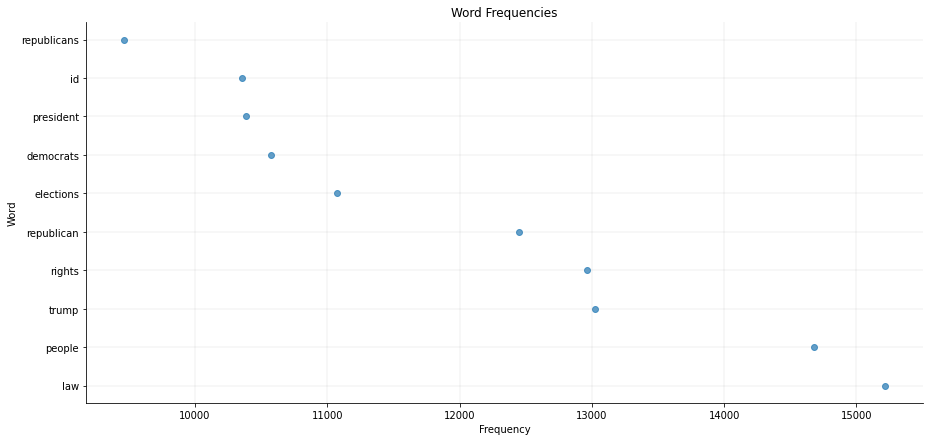

In [109]:
# Plotting top words
scatterplot(cnt_df, 'freq', 'df')

In [110]:
# preprocess title
df['pptitle']=df['title'].apply(str) # Converting text column into string so that preprocessing works
df['pptitle'] = df['pptitle'].apply(nostop)
df['pptitle'] = df['pptitle'].apply(preprocess)
df['pptitle'] = df['pptitle'].apply(idfwords)
df['pptitle'] = df['pptitle'].apply(bigrams)

In [29]:
# Checking amount of words after preprocessing
text =df['text'].apply(str) 
tokens = [" ".join(strings.split()) for strings in text] 
string = " ".join(tokens)
tokenized = word_tokenize(string)
len(string)

19705018

In [28]:
# save data to csv file
df.to_csv('preprocessed.csv', index = False)

In [65]:
# export text data to txt file for Iramuteq analysis
# left media
articles_l =left['lemma'].apply(str) 
with open('articles_left.txt', 'w') as f:
    for line in articles_l:
        f.write(line)
        f.write(' ')

# right media
articles_r =right['lemma'].apply(str) 
with open('articles_right.txt', 'w') as f:
    for line in articles_r:
        f.write(line)
        f.write(' ')

In [ ]:
# all articles
articletext = df['text'].apply(str) 
with open('text.txt', 'w') as f:
    for line in articletext:
        f.write(line)
        f.write(' ')